# Обучение и валидация

Для обучения и валидации была выбрана библиотека [detectron2](https://github.com/facebookresearch/detectron2).

Все модели из зоопарка моделей detectron2 были обучены на датасете MS-COCO 2017г, но пайплайн обучения я на всякий случай написал.

Инференс полученной модели можно выполнить в блокноте ```inference.ipynb```



## Скачивание датасета

In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip

In [2]:
!wget http://images.cocodataset.org/zips/val2017.zip

In [3]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [4]:
!unzip annotations_trainval2017.zip -d /app/dataset

In [5]:
!unzip val2017.zip -d /app/dataset

In [6]:
!unzip train2017.zip -d /app/dataset

## Просмотр датасета

Посмотреть на весь датасет можно с помощью [fiftyon](https://docs.voxel51.com/)

In [7]:
dataDir = '/app/dataset'
dataType = 'train2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'
imgDir= f'{dataDir}/{dataType}'

In [8]:
from pycocotools.coco import COCO

coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
categories = [cat['name'] for cat in cats]

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [9]:
print(f"Количество категорий: {len(categories)}")
print()
print("Категории:")
print(categories)

Количество категорий: 80

Категории:
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [10]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import load_coco_json

import matplotlib.pyplot as plt
import cv2

my_dataset = load_coco_json(json_file= annFile, image_root=f"{dataDir}/{dataType}" , dataset_name = 'my_dataset')
dataset_metadata = MetadataCatalog.get("my_dataset").set(thing_classes=categories)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [11]:
TOTAL_NUM_IMAGES = len(my_dataset)

print(f"Количество изображений: {TOTAL_NUM_IMAGES}")

Количество изображений: 5000


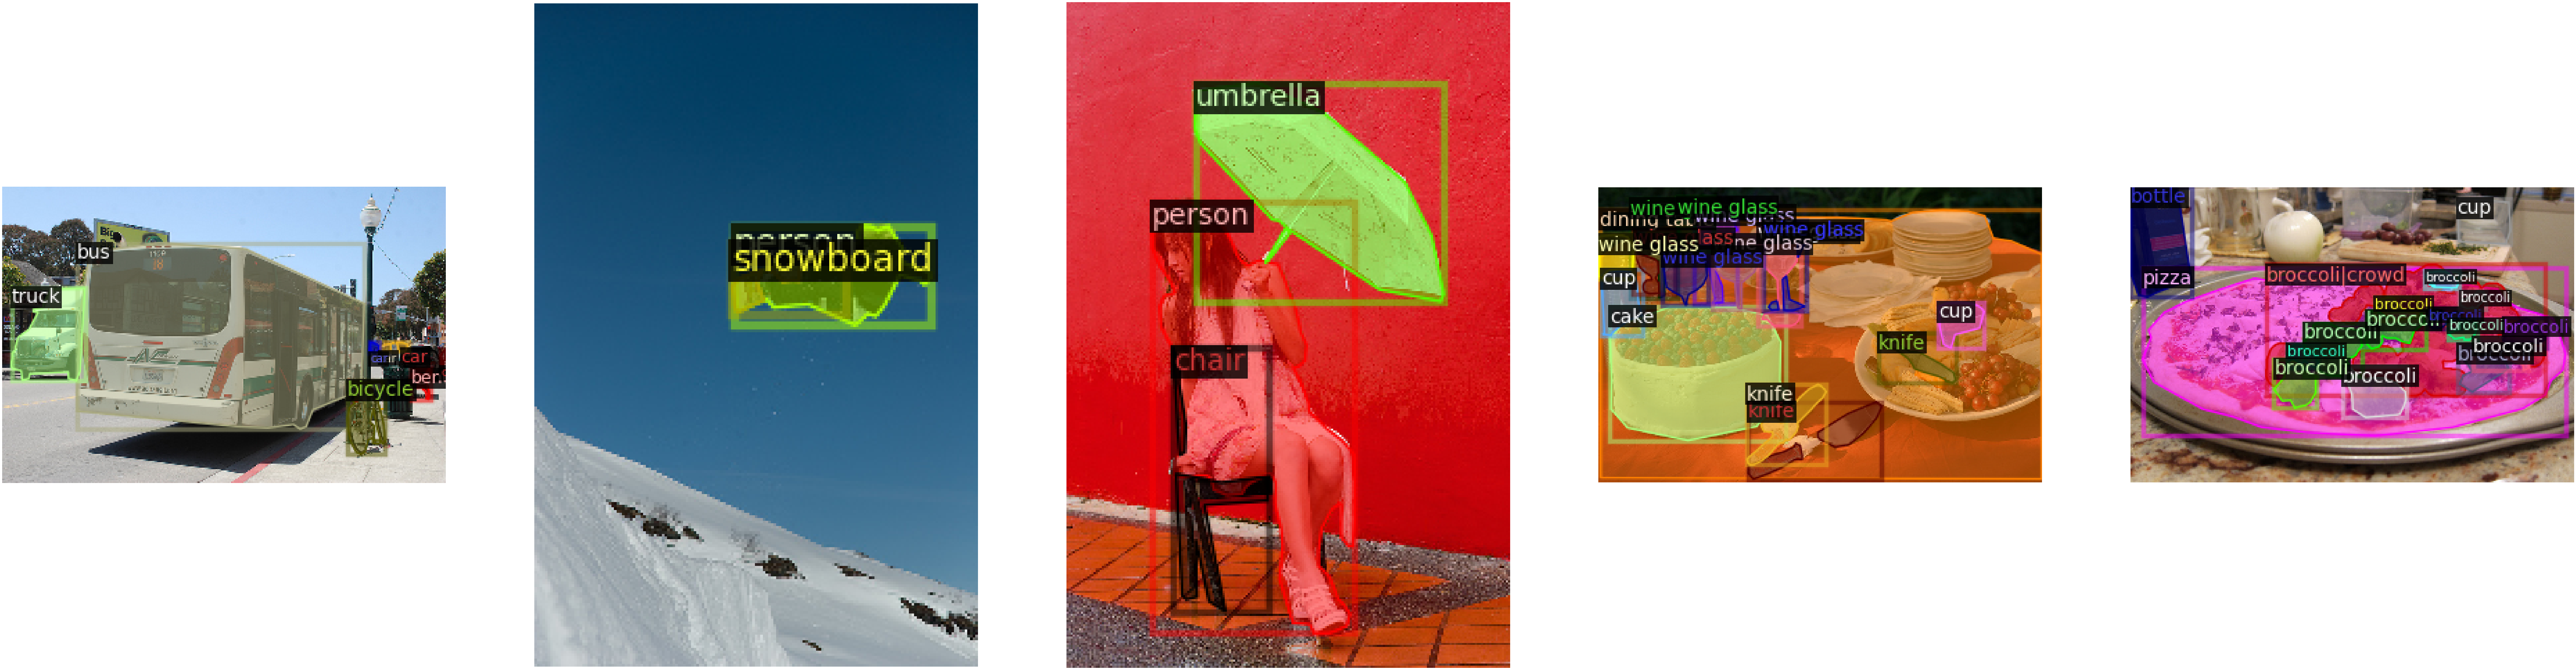

In [12]:
import random
from PIL import Image

number_of_samples = 5
imgs = []
ids = random.sample([i for i in range(len(my_dataset))], number_of_samples)
for i in ids:
    element_id = i
    img = cv2.imread(my_dataset[element_id]["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(my_dataset[element_id])
    imgs.append(Image.fromarray(out.get_image()))
    
_, axs = plt.subplots(1, len(imgs), figsize=(150, 150))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.axis('off')
    ax.imshow(img)
plt.show()

## Обучение

Чекпоинты при обучении сохраняются каждые 5000 итераций.

За обучением можно наблюдать в TensorBoard

In [13]:
import os
import torch
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances

Регистрируем датасет

Чтобы выполнить обучение модели на своих данных необходимо правильно указать пути к изображениям и аннотациям.

**Разметка датасета должа быть в формате COCO**

In [14]:
setup_logger()
data_dir='/app/dataset'
train_ann = '/app/dataset/annotations/instances_train2017.json'
val_ann = '/app/dataset/annotations/instances_val2017.json'

register_coco_instances("train_dataset", {}, train_ann, f"{data_dir}/train2017")
register_coco_instances("val_dataset", {}, val_ann, f"{data_dir}/val2017")

In [15]:
train_dataset = DatasetCatalog.get("train_dataset")

WARNING [02/04 11:01:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/04 11:01:34 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /app/dataset/annotations/instances_val2017.json


Выбираем модель и запускаем обучение

In [16]:
TOTAL_NUM_IMAGES = len(train_dataset)
NUMBER_OF_EPOCH = 1
IMS_PER_BATCH = 2
weights_path = '/app/checkpoints/detectron2/faster_rcnn_R_50'
iterations_for_one_epoch = TOTAL_NUM_IMAGES / IMS_PER_BATCH
number_of_iter = int(iterations_for_one_epoch * NUMBER_OF_EPOCH)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.OUTPUT_DIR = weights_path
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = IMS_PER_BATCH
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = number_of_iter
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categories)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False) # Если хотим продолжить обучение, то ставим True
trainer.train()

[02/04 11:01:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/opt/conda/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/04 11:01:46 d2.utils.events]:  eta: 0:09:53  iter: 19  total_loss: 0.5487  loss_cls: 0.2639  loss_box_reg: 0.2149  loss_rpn_cls: 0.0259  loss_rpn_loc: 0.05732  time: 0.2393  data_time: 0.0135  lr: 4.9953e-06  max_mem: 2642M
[02/04 11:01:51 d2.utils.events]:  eta: 0:09:48  iter: 39  total_loss: 0.5608  loss_cls: 0.2108  loss_box_reg: 0.2499  loss_rpn_cls: 0.03378  loss_rpn_loc: 0.0582  time: 0.2375  data_time: 0.0029  lr: 9.9902e-06  max_mem: 2642M
[02/04 11:01:55 d2.utils.events]:  eta: 0:09:40  iter: 59  total_loss: 0.4873  loss_cls: 0.1851  loss_box_reg: 0.1805  loss_rpn_cls: 0.0139  loss_rpn_loc: 0.05089  time: 0.2357  data_time: 0.0033  lr: 1.4985e-05  max_mem: 2642M
[02/04 11:02:00 d2.utils.events]:  eta: 0:09:30  iter: 79  total_loss: 0.5075  loss_cls: 0.2032  loss_box_reg: 0.2189  loss_rpn_cls: 0.03684  loss_rpn_loc: 0.06676  time: 0.2349  data_time: 0.0033  lr: 1.998e-05  max_mem: 2733M
[02/04 11:02:04 d2.utils.events]:  eta: 0:09:24  iter: 99  total_loss: 0.5443  loss_cls:

## TensorBoard

In [4]:
%load_ext tensorboard
%tensorboard --logdir /app/checkpoints/detectron2/faster_rcnn_R_50 --host jupyter --port 5151

## Валидация

Для валидации модели было выбрана метрика Average Precision при разных диапазонах IoU, т.к. она является наиболее популярной метрикой для оценки моделей детекции и мы можем легко сравнить полученные метрики с метриками из [таблицы](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) в документации.

In [17]:
from detectron2.engine import DefaultPredictor

weights_path = '/app/checkpoints/detectron2/faster_rcnn_R_50/model_final.pth'

cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/04 11:11:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /app/checkpoints/detectron2/faster_rcnn_R_50/model_final.pth ...


In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val_dataset", output_dir="/app/checkpoints/detectron2/faster_rcnn_R_50/COCOEvaluator")
val_loader = build_detection_test_loader(cfg, "val_dataset")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [02/04 11:11:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/04 11:11:30 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /app/dataset/annotations/instances_val2017.json
[02/04 11:11:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/04 11:11:30 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/04 11:11:30 d2.data.common]: Serializing 5000 elements to byte tensors and concatenating them all ...
[02/04 11:11:31 d2.data.common]: Serialized dataset takes 19.09 MiB
[02/04 11:11:31 d2.evaluation.evaluator]: Start inference on 5000 batches
[02/04 11:11:31 d2.evaluation.evaluator]: Inference done 11/5000. Dataloading: 0.0009 s/iter. Inference: 0.0520 s/iter. Eval: 0.0002 s/iter. Total: 0.0531 s/iter. ETA=0:04:25
[02/04 11:11:36

## Экспорт модели в формат torchscript

Чтобы использовать обученную модель в [Nvidia Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server) необходимо ее экспортировать в формат torchscript:

```
python /app/detectron2/tools/deploy/export_model.py \
    --format torchscript \
    --export-method tracing \
    --config-file /app/configs/custom_faster_rcnn_R_50_FPN_3x.yaml \
    --sample-image /app/dataset/test_imgs/input.jpg \
    --output /app/checkpoints/torchscript/faster_rcnn
```


In [ ]:
!python /app/detectron2/tools/deploy/export_model.py \
    --format torchscript \
    --export-method tracing \
    --config-file /app/configs/custom_faster_rcnn_R_50_FPN_3x.yaml \
    --sample-image /app/dataset/test_imgs/input.jpg \
    --output /app/checkpoints/torchscript/faster_rcnn